# Similarity

In [1]:
# Librairies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import *

import re
import random
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics.pairwise import cosine_similarity
import Levenshtein
from scipy.spatial import distance
from scipy.special import binom
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 100)

## Load data

In [3]:
# Import dataset
df = pd.read_csv('../../Data/data_similary_products.csv')
df.rename(columns={'product_name': 'productseller_name'}, inplace=True)

In [4]:
df.brand_seller.fillna("", inplace=True)
df.drop(df[df.product_price.isna()].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [5]:
df.head(1)

id_page  index_data  \
0  /type/7612895071961.html           0   

                                                                                    productseller_name  \
0  SikaCeram Xtra, Colle à carrelage intérieur et extérieur pour carreaux 60x60 max (C2-ET), 25kg, ...   

    brand_seller  product_price url_image  label  
0  SIKAFRANCESAS           31.4         0     27

## Preprocessing 

### Extraction des attributs

In [6]:
# Lettre en minuscule
df['productseller_name'] = df['productseller_name'].str.lower()
df['brand_seller'] = df['brand_seller'].str.lower()

In [7]:
# Récupérer les attributs : Poids, Mesure, Volume, Couleur etc
def preprocessing_attributs(df, name_col):
    df['Poids'] = df[name_col].apply(lambda x: re.search(r"([\d.,]+)\s*(g|grammes|kg)\b", x).group() if re.search(r"([\d.,]+)\s*(g|grammes|kg)\b", x) is not None else '')
    df['Mesure'] = df[name_col].apply(lambda x: re.search(r"([\d.,]+)\s*(mm|cm|m|mètres|mètre)\b", x).group() if re.search(r"([\d.,]+)\s*(mm|cm|m|mètres|mètre)\b", x) is not None else '')
    df['Volume'] = df[name_col].apply(lambda x: re.search(r"([\d.,]+)\s*(ml|cl|l|litres|litre|cm³)\b", x).group() if re.search(r"([\d.,]+)\s*(ml|cl|l|litres|litre|cm³)\b", x) is not None else '')
    df['Volt'] = df[name_col].apply(lambda x: re.sub(r"([\d.,]+)\s*(v|volts|volt)\b", r"\1", re.search(r"([\d.,]+)\s*(v|volts|volt)\b", x).group()) if re.search(r"([\d.,]+)\s*(v|volts|volt)\b", x) is not None else '')
    df['Watt'] = df[name_col].apply(lambda x: re.sub(r"([\d.,]+)\s*(w|watts|watt)\b", r"\1", re.search(r"([\d.,]+)\s*(w|watts|watt)\b", x).group()) if re.search(r"([\d.,]+)\s*(w|watts|watt)\b", x) is not None else '')
    df['AmpereHeure'] = df[name_col].apply(lambda x: re.sub(r"([\d.,]+)\s*(ah)\b", r"\1", re.search(r"([\d.,]+)\s*(ah)\b", x).group()) if re.search(r"([\d.,]+)\s*(ah)\b", x) is not None else '')
    df['NewtonMetre'] = df[name_col].apply(lambda x: re.sub(r"([\d.,]+)\s*(nm)\b", r"\1", re.search(r"([\d.,]+)\s*(nm)\b", x).group()) if re.search(r"([\d.,]+)\s*(nm)\b", x) is not None else '')
    df['Rpm'] = df[name_col].apply(lambda x: re.sub(r"([\d.,]+)\s*(nm)\b", r"\1", re.search(r"([\d.,]+)\s*(nm)\b", x).group()) if re.search(r"([\d.,]+)\s*(nm)\b", x) is not None else '')
    df['Joules'] = df[name_col].apply(lambda x: re.sub(r"([\d.,]+)\s*(j|joules)\b", r"\1", re.search(r"([\d.,]+)\s*(j|joules|joule)\b", x).group()) if re.search(r"([\d.,]+)\s*(j|joules|joule)\b", x) is not None else '')
    df['Metre2'] = df[name_col].apply(lambda x: re.sub(r"([\d.,]+)\s*(m²)\b", r"\1", re.search(r"([\d.,]+)\s*(m²)\b", x).group()) if re.search(r"([\d.,]+)\s*(m²)\b", x) is not None else '')
    df['Batterie'] = df[name_col].apply(lambda x: re.sub(r"([\d.,]+)\s*(batteries|batterie)\b", r"\1", re.search(r"([\d.,]+)\s*(batteries|batterie)\b", x).group()) if re.search(r"([\d.,]+)\s*(batteries|batterie)\b", x) is not None else '')
    df['Couleur'] = df[name_col].apply(lambda x: re.search(r"\b(gris|noir|marron|beige|rouge|blanc|bleu|vert|argent|jaune|orange|multicolore)\b", x).group() if re.search(r"\b(gris|noir|marron|beige|rouge|blanc|bleu|vert|argent|jaune|orange|multicolore)\b", x) is not None else '')
    return df

df = preprocessing_attributs(df, 'productseller_name')

In [10]:
# Retirer les unités de mesure et marque de la description
def preprocessing_description(df, name_col):
    df['Description'] = df[name_col].apply(lambda x: re.sub(r"([\d.,]+)\s*(g|gramme|grammes|kg|mm|cm|m|mètre|mètres|ml|cl|l|litre|litres|v|volt|volts|w|watt|watts|ah|nm|rpm|j|joule|joules|cm³|m²)\b", "", x))
    df['Description'] = df['Description'].apply(lambda x: re.sub(r"(gris|noir|marron|beige|rouge|blanc|bleu|vert|argent|jaune|orange|multicolore)\b", "", x))
    
    # Liste des marques
    unique_brand = open('../../Data/unique_brand.txt').read().split(',')
    unique_brand = [x for x in unique_brand]
    regex = r'(' + r'|'.join(unique_brand) + r')'
    df['Description'] = df['Description'].apply(lambda x: re.sub(regex, "", x))
    return df

df = preprocessing_description(df, 'productseller_name')

In [11]:
# Normaliser unité de mesure 
# Exemple : poids en gramme, mesure en mètre, volume en litre etc
def normalization_unit(df, name_col):
    dico = {'Poids':{'g':1, 'kg':1000}, 'Mesure':{'mm':0.001, 'm':1, 'cm':0.01}, 'Volume':{'ml':0.001, 'cl':0.01, 'l':1, 'cm³':0.001}}
    dico_regex = {'Poids':'(g|kg)', 'Mesure':'(mm|cm|m)', 'Volume':'(ml|cl|l|cm³)'}
    df[name_col + '_unit'] = df[name_col].apply(lambda x: float(re.search('\d+', x).group())*dico[name_col][re.search(dico_regex[name_col], x).group()] if re.search("\d+", x) and re.search(dico_regex[name_col], x) is not None else '')
    return df

df = normalization_unit(df, 'Poids')
df = normalization_unit(df, 'Mesure')
df = normalization_unit(df, 'Volume')

In [14]:
# Ajouter les marques 
def brand(df):
    
    # Liste des marques
    unique_brand = open('../../Data/unique_brand.txt').read().split(',')
    unique_brand = [x for x in unique_brand]
    regex = r'\b(' + r'|'.join(unique_brand) + r')\b'
    regex2 = r'(' + r'|'.join(unique_brand) + r')'
    
    # Marque pour chaque produit
    df['brand'] = df['productseller_name'].apply(lambda x: re.search(regex, x).group() if re.search(regex, x) is not None else '')
    
    # Gestion sans marque suite à la première regex
    index_no_brand = df[df.brand == ''].index.tolist()
    for index in index_no_brand:
        if re.search(regex2, df['brand_seller'].iloc[index]) is not None:
            df['brand'].iloc[index] = re.search(regex2, df['brand_seller'].iloc[index]).group() 
        elif re.search(regex2, df['productseller_name'].iloc[index]) is not None:
            df['brand'].iloc[index] = re.search(regex2, df['productseller_name'].iloc[index]).group() 
        else:
            df['brand'].iloc[index] = ''
        
    return df

df = brand(df)

In [15]:
# Ajouter les modèles
def model(df):
    # mise en place regex
    regex = r'[a-z0-9]+[-]?[0-9]+[a-z0-9]+(?= )'
    # Marque pour chaque produit
    df['model'] = df['Description'].apply(lambda x: re.search(regex, x).group() if re.search(regex, x) is not None else '')
    return df

df = model(df)

In [16]:
# Cas spécial : black and decker
df['brand'] = df['brand'].apply(lambda x: 'blackanddecker' if x in ['black & decker','black and decker', 'black + decker'] else x)

# Clean description : retirer les modèles
df['Description'] = df['Description'].apply(lambda x: re.sub(r"[a-z0-9]+[-]?[0-9]+[a-z0-9]+(?= )", "", x))

In [17]:
# Mise au propre du dataframe
#df = df.drop(['Poids', 'Mesure', 'Volume'],1)

col = ['id_page',
       'index_data',
       'label',
       'productseller_name',
       'brand',
       'Description',
       'Volume_unit',
       'Mesure_unit',
       'Poids_unit',
       'AmpereHeure',
       'NewtonMetre',
       'Watt',
       'Volt',
       'Rpm',
       'Joules',
       'Metre2',
       'Batterie',
       'Couleur',
       'product_price',
       'model']

df = df[col]

### Conversion des données 

In [18]:
# Conversion des données en float
# NaN pour les champs vide par défaut, possible de paramétrer
df['Volume_unit'] = df['Volume_unit'].apply(lambda x: float(x) if x != '' else np.NaN)
df['Poids_unit'] = df['Poids_unit'].apply(lambda x: float(x) if x != '' else np.NaN)
df['Mesure_unit'] = df['Mesure_unit'].apply(lambda x: float(x) if x != '' else np.NaN)
df['Joules'] = df['Joules'].apply(lambda x: float(x.replace(',','.')) if x != '' else np.NaN)
df['Rpm'] = df['Rpm'].apply(lambda x: float(x) if x != '' else np.NaN)
df['Metre2'] = df['Metre2'].apply(lambda x: float(x) if x != '' else np.NaN)
df['AmpereHeure'] = df['AmpereHeure'].apply(lambda x: float(x.replace(',','.')) if x != '' else np.NaN)
df['Watt'] = df['Watt'].apply(lambda x: float(x.replace(',','.')) if x != '' else np.NaN)
df['Volt'] = df['Volt'].apply(lambda x: float(x.replace(',','.')) if x != '' else np.NaN)
df['NewtonMetre'] = df['NewtonMetre'].apply(lambda x: float(x.replace(',','.')) if x != '' else np.NaN)

In [19]:
# Dans le cas où la valeur est nulle, on met valeurs Nan
df['Volume_unit'] = df['Volume_unit'].apply(lambda x: x if x != 0 else np.NaN)
df['Poids_unit'] = df['Poids_unit'].apply(lambda x: x if x != 0 else np.NaN)
df['Mesure_unit'] = df['Mesure_unit'].apply(lambda x: x if x != 0 else np.NaN)
df['Joules'] = df['Joules'].apply(lambda x: x if x != 0 else np.NaN)
df['Rpm'] = df['Rpm'].apply(lambda x: x if x != 0 else np.NaN)
df['Metre2'] = df['Metre2'].apply(lambda x: x if x != 0 else np.NaN)
df['AmpereHeure'] = df['AmpereHeure'].apply(lambda x: x if x != 0 else np.NaN)
df['Watt'] = df['Watt'].apply(lambda x: x if x != 0 else np.NaN)
df['Volt'] = df['Volt'].apply(lambda x: x if x != 0 else np.NaN)
df['NewtonMetre'] = df['NewtonMetre'].apply(lambda x: x if x != 0 else np.NaN)

### Preprocessing description

In [20]:
stop_words = load_txt("../../Data/stop_words.txt")

In [20]:
preprocessing(df, ['Description'], stop_words, 'C:/TreeTagger')
df = df.drop('Description_treetagger',1)

### TF IDF / NMF

In [21]:
# Embedding
tfidf = TfidfVectorizer(lowercase=False)
tf_idf = csr_matrix(tfidf.fit_transform(df.Description_clean.values))
nmf = NMF(n_components=250, alpha=.1, l1_ratio=.5).fit_transform(tf_idf)
topics = ["topic_"+str(i) for i in range(250)]
df_topics = pd.DataFrame(nmf, columns=topics).set_index(df.index)

df = pd.concat((df, df_topics), axis=1)

## Tests métriques

In [22]:
# Define the KNNClassifier Class :
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances

class KNNClassifier(BaseEstimator, ClassifierMixin):
    """Home made KNN Classifier class."""

    def __init__(self, n_neighbors=1, distance=None):
        self.n_neighbors = n_neighbors
        self.distance = distance

    def fit(self, X, y):
        self.X_ = X.ravel()
        self.y_ = y
        return self

    def predict(self, X):
        # Calcule the distances
        n_samples, n_features = X.shape
        dist = np.zeros((n_samples, self.X_.shape[0]))
        vfunc = np.vectorize(self.distance)
        for i in range(n_samples):
            dist[i,:] = vfunc(X[i][0], self.X_)
        # Get indices to sort them
        idx_sort = np.argsort(dist)
        # Get indices of neighbors
        idx_neighbors = idx_sort[:,0:self.n_neighbors]
        # Get labels of neighbors
        y_neighbors = self.y_[idx_neighbors]
        # Find the predicted labels y for each entry in X
        mode2, _ = mode(y_neighbors, axis=1)[0], mode(y_neighbors)[1]
        # the following might be needed for dimensionality
        y_pred = np.asarray(mode2.ravel())
        return y_pred

### Modèle - Distance Levenshtein

#### One product demo

In [23]:
# On se concentre sur une catégorie pour commencer
category = 55
df_category = df[df.label == category]

In [24]:
df_category = df_category[df_category.model!=""]
list_products = df_category.id_page.value_counts().index.values[df_category.id_page.value_counts()>1]
df_category = df_category[df_category.id_page.isin(list_products)]

In [25]:
print("Nombre de produits avec plusieurs apparaitions dans la catégorie {} : ".format(category), df_category.shape[0])
print("Nombre de produits uniques avec plusieurs apparaitions dans la catégorie {} : ".format(category), len(df_category.id_page.unique()))

Nombre de produits avec plusieurs apparaitions dans la catégorie 55 :  84
Nombre de produits uniques avec plusieurs apparaitions dans la catégorie 55 :  23


In [26]:
product_to_compare = df_category.index.values[0]

In [27]:
df_category.id_page.loc[product_to_compare]

'/prix/3491628/bosch-f016800303.html'

In [28]:
# On calcule la distance du premier produit par rapport à tous les autres produits de cette catégorie
df_category["levenshtein"] = df_category.model.apply(lambda x: Levenshtein.distance(x, df_category.model.loc[product_to_compare]))

In [29]:
df_category.drop(index=product_to_compare).groupby("id_page").mean().sort_values("levenshtein")

index_data  label  Volume_unit  \
id_page                                                               
/prix/3491628/bosch-f016800303.html       202.0   55.0          NaN   
/type/4006885411104.html                 2436.0   55.0          NaN   
/type/4006885411302.html                 2463.0   55.0          NaN   
/prix/998866/aeg-st-800-xe.html          3492.0   55.0          NaN   
/prix/3939158/ryobi-rak03sr.html          208.0   55.0          NaN   
/type/4002395332526.html                16511.0   55.0          NaN   
/type/4002395368044.html                16129.0   55.0          NaN   
/type/4892210121271.html                17460.0   55.0          NaN   
/type/4892210116444.html                18306.0   55.0          NaN   
/type/4002395369294.html                17735.0   55.0          NaN   
/type/4892210120847.html                15752.0   55.0          NaN   
/type/4892210115942.html                17371.0   55.0          NaN   
/type/4892210135599.html                  334.0   55.0          NaN   
/type/4892210134042.html                  557.0   55.0          NaN   
/type/4892210119292.html                18322.0   55.0          NaN   
/type/4892210114396.html                  212.0   55.0          NaN   
/type/4002395369027.html                15763.0   55.0          NaN   
/type/4002395361151.html                  617.0   55.0          NaN   
/type/790295540922.html                   713.0   55.0          NaN   
/type/4892210818355.html                  452.0   55.0          NaN   
/type/4002395369140.html                  753.0   55.0          NaN   
/type/4002395368952.html                17926.0   55.0          NaN   
/type/4892210115843.html                15909.0   55.0          NaN   

                                     Mesure_unit  Poids_unit  AmpereHeure  \
id_page                                                                     
/prix/3491628/bosch-f016800303.html        0.150         NaN          NaN   
/type/4006885411104.html                   0.005         NaN          NaN   
/type/4006885411302.html                   0.005         NaN          NaN   
/prix/998866/aeg-st-800-xe.html            0.110         NaN          NaN   
/prix/3939158/ryobi-rak03sr.html           0.637         NaN          NaN   
/type/4002395332526.html                   0.120         NaN          NaN   
/type/4002395368044.html                   0.055         NaN          NaN   
/type/4892210121271.html                   0.095         NaN          NaN   
/type/4892210116444.html                     NaN         NaN          NaN   
/type/4002395369294.html                   0.140         NaN          NaN   
/type/4892210120847.html                   0.533         NaN          NaN   
/type/4892210115942.html                   0.099         NaN          NaN   
/type/4892210135599.html                   0.165         NaN          NaN   
/type/4892210134042.html                   0.330         NaN          NaN   
/type/4892210119292.html                     NaN         NaN          NaN   
/type/4892210114396.html                     NaN         NaN          NaN   
/type/4002395369027.html                     NaN         NaN          NaN   
/type/4002395361151.html                     NaN         NaN          NaN   
/type/790295540922.html                      NaN         NaN          NaN   
/type/4892210818355.html                   0.530         NaN          NaN   
/type/4002395369140.html                     NaN         NaN          NaN   
/type/4002395368952.html                     NaN         NaN          NaN   
/type/4892210115843.html                     NaN         NaN          NaN   

                                     NewtonMetre   Watt  Volt  Rpm  Joules  \
id_page                                                                      
/prix/3491628/bosch-f016800303.html          NaN    NaN   NaN  NaN     NaN   
/type/4006885411104.html                     NaN    NaN   NaN  NaN     NaN   
/type/4006885411302.htm

In [30]:
df_category.head(60)

id_page  index_data  label  \
942   /prix/3491628/bosch-f016800303.html         202     55   
943   /prix/3491628/bosch-f016800303.html         202     55   
951      /prix/3939158/ryobi-rak03sr.html         208     55   
952      /prix/3939158/ryobi-rak03sr.html         208     55   
954      /prix/3939158/ryobi-rak03sr.html         208     55   
959      /prix/3939158/ryobi-rak03sr.html         208     55   
964              /type/4892210114396.html         212     55   
965              /type/4892210114396.html         212     55   
1145             /type/4892210135599.html         334     55   
1146             /type/4892210135599.html         334     55   
1309             /type/4892210818355.html         452     55   
1313             /type/4892210818355.html         452     55   
1314             /type/4892210818355.html         452     55   
1382             /type/4892210134042.html         557     55   
1383             /type/4892210134042.html         557     55   
1385             /type/4892210134042.html         557     55   
1386             /type/4892210134042.html         557     55   
1388             /type/4892210134042.html         557     55   
1433             /type/4002395361151.html         617     55   
1435             /type/4002395361151.html         617     55   
1436             /type/4002395361151.html         617     55   
1438             /type/4002395361151.html         617     55   
1514              /type/790295540922.html         713     55   
1530             /type/4002395369140.html         753     55   
1531             /type/4002395369140.html         753     55   
1861             /type/4006885411104.html        2436     55   
1864             /type/4006885411104.html        2436     55   
1927             /type/4006885411302.html        2463     55   
1931             /type/4006885411302.html        2463     55   
3040      /prix/998866/aeg-st-800-xe.html        3492     55   
3041      /prix/998866/aeg-st-800-xe.html        3492     55   
3042      /prix/998866/aeg-st-800-xe.html        3492     55   
3043      /prix/998866/aeg-st-800-xe.html        3492     55   
3045      /prix/998866/aeg-st-800-xe.html        3492     55   
3049      /prix/998866/aeg-st-800-xe.html        3492     55   
3050      /prix/998866/aeg-st-800-xe.html        3492     55   
3323             /type/4892210120847.html       15752     55   
3324             /type/4892210120847.html       15752     55   
3325             /type/4892210120847.html       15752     55   
3326             /type/4892210120847.html       15752     55   
3327             /type/4892210120847.html       15752     55   
3328             /type/4892210120847.html       15752     55   
3329             /type/4002395369027.html       15763     55   
3334             /type/4002395369027.html       15763     55   
3417             /type/4892210115843.html       15909     55   
3418             /type/4892210115843.html       15909     55   
3437             /type/4002395368044.html       16129     55   
3438             /type/4002395368044.html       16129     55   
3504             /type/4002395332526.html       16511     55   
3505             /type/4002395332526.html       16511     55   
3506             /type/4002395332526.html       16511     55   
3732             /type/4892210115942.html       17371     55   
3733             /type/4892210115942.html       17371     55   
3735             /type/4892210115942.html       17371     55   
3736             /type/4892210115942.html       17371     55   
3737             /type/4892210115942.html       17371     55   
3738             /type/4892210115942.html       17371     55   
3739             /type/4892210115942.html       17371     55   
3740             /type/4892210115942.html       17371     55   
3749             /type/4892210121271.html       17460     55   

                                                                                       productseller_name  \
942                 

#### KNN model

In [31]:
df_category = df[df.model!=""]
list_products = df_category.id_page.value_counts().index.values[df_category.id_page.value_counts()>1]
df_category = df_category[df_category.id_page.isin(list_products)]

In [32]:
categories = df_category.label.unique()
scores = []
for category in categories:
    df_temp = df_category[df_category.label == category]
    X = df_temp.model.values.reshape(-1, 1)
    y = df_temp.id_page.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = KNNClassifier(n_neighbors=1, distance=Levenshtein.distance)
    clf.fit(X_train, y_train)
    scores.append(accuracy_score(clf.predict(X_test), y_test))

C:\Users\Pascal\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [33]:
np.mean(scores)

0.8936894344514666

### Prix - Distance euclidienne standardisée

In [34]:
def euclidian_distance_customed(price, price_ref):
    return np.sqrt(((price-price_ref)/(price_ref*price))**2)

#### Demo one product

In [35]:
# On se concentre sur une catégorie pour commencer
category = 55
df_category = df[df.label == category]

In [36]:
df_category = df_category[df_category.product_price != 0]
list_products = df_category.id_page.value_counts().index.values[df_category.id_page.value_counts()>1]
df_category = df_category[df_category.id_page.isin(list_products)]

In [37]:
print("Nombre de produits avec plusieurs apparaitions dans la catégorie {} : ".format(category), df_category.shape[0])
print("Nombre de produits uniques avec plusieurs apparaitions dans la catégorie {} : ".format(category), len(df_category.id_page.unique()))

Nombre de produits avec plusieurs apparaitions dans la catégorie 55 :  361
Nombre de produits uniques avec plusieurs apparaitions dans la catégorie 55 :  45


In [38]:
product_to_compare = df_category.index.values[0]

In [39]:
df_category.id_page.loc[product_to_compare]

'/prix/5641246/ryobi-rc18627.html'

In [41]:
# On calcule la distance du premier produit par rapport à tous les autres produits de cette catégorie
df_category["price_diff_custom"] = df_category.product_price.apply(lambda x: euclidian_distance_customed(x, df_category.product_price.loc[product_to_compare]))

In [42]:
df_category.drop(index=product_to_compare).groupby("id_page").mean().sort_values("price_diff_custom")

index_data  \
id_page                                                                               
/prix/5641246/ryobi-rc18627.html                                               4481   
/prix/5943644/aeg-omni-mtx.html                                               10167   
/type/4002395134724.html                                                      16790   
/prix/998866/aeg-st-800-xe.html                                                3492   
/prix/5820561/ryobi-rc18150.html                                               4902   
/type/4002395369027.html                                                      15763   
/prix/3721314/ryobi-chargeur-rapide-1h-lithium-ion-nicad-bcl14181h.html        4841   
/prix/3939158/ryobi-rak03sr.html                                                208   
/type/4892210158512.html                                                       4827   
/type/4892210115843.html                                                      15909   
/prix/1678959/ryobi-utb-4.html                                                 4601   
/type/4892210818355.html                                                        452   
/type/4002395369140.html                                                        753   
/type/4002395368952.html                                                      17926   
/type/4892210813770.html                                                        309   
/type/4892210128645.html                                                      16379   
/type/4892210114396.html                                                        212   
/type/4002395373437.html                                                      15840   
/type/4892210116444.html                                                      18306   
/prix/3491628/bosch-f016800303.html                                             202   
/type/4892210134042.html                                                        557   
/type/4892210119292.html                                                      18322   
/type/4892210135599.html                                                        334   
/type/4006885411302.html                                                       2463   
/type/4892210143280.html                                                      17842   
/type/4892210121271.html                                                      17460   
/type/4006885411104.html                                                       2436   
/type/4892210121257.html                                                      17835   
/type/4892210120847.html                                                      15752   
/type/4892210115942.html                                                      17371   
/type/4892210120823.html                                                      18220   
/type/4892210116802.html                                                      18001   
/type/4002395369287.html                                                      16249   
/type/4002395369294.html                                                      17735   
/type/4002395304240.html                                                        482   
/type/790295540922.html                                                         713   
/type/4892210113306.html                                                      18183   
/type/4892210125422.html                                                      15841   
/type/4002395368044.html                                                      16129   
/type/4002395361151.html                                                        617   
/type/4002395301539.html                                                      17327   
/type/4002395332526.html                                                      16511   
/type/4002395332502.html                                                      15811   
/type/4002395333967.html                                                      16531   
/type/4892210128966.html                                               

In [43]:
from scipy.interpolate import interp1d
m = interp1d([np.min(df_category["price_diff_custom"].values), np.max(df_category["price_diff_custom"].values)],[0, 1])

In [44]:
df_category["price_diff_std"] = df_category["price_diff_custom"].apply(lambda x: m(x))

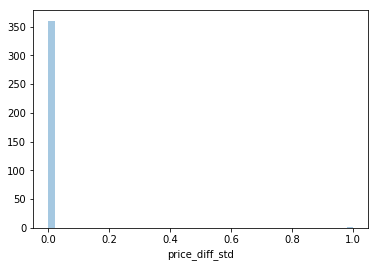

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(df_category["price_diff_std"], bins=50, kde=False)

#### KNN model

In [46]:
df_category = df[df.product_price!=0]
list_products = df_category.id_page.value_counts().index.values[df_category.id_page.value_counts()>1]
df_category = df_category[df_category.id_page.isin(list_products)]

In [47]:
categories = df_category.label.unique()
scores = []
for category in categories:
    df_temp = df_category[df_category.label == category]
    X = df_temp.product_price.values.reshape(-1, 1)
    y = df_temp.id_page.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = KNNClassifier(n_neighbors=1, distance=euclidian_distance_customed)
    clf.fit(X_train, y_train)
    scores.append(accuracy_score(clf.predict(X_test), y_test))

In [48]:
np.mean(scores)

0.6811861860690165

### Marque - Booléen

In [60]:
def booelan_distance(attr1, attr2):
    if attr1 == "" or attr2=="":
        return 0.5
    elif attr1 == attr2:
        return 0
    else:
        return 1

#### Demo one product

In [61]:
# On se concentre sur une catégorie pour commencer
category = 55
df_category = df[df.label == category]

In [62]:
df_category = df_category[df_category.brand != ""]
list_products = df_category.id_page.value_counts().index.values[df_category.id_page.value_counts()>1]
df_category = df_category[df_category.id_page.isin(list_products)]

In [63]:
print("Nombre de produits avec plusieurs apparaitions dans la catégorie {} : ".format(category), df_category.shape[0])
print("Nombre de produits uniques avec plusieurs apparaitions dans la catégorie {} : ".format(category), len(df_category.id_page.unique()))

Nombre de produits avec plusieurs apparaitions dans la catégorie 55 :  361
Nombre de produits uniques avec plusieurs apparaitions dans la catégorie 55 :  45


In [64]:
product_to_compare = df_category.index.values[0]

In [65]:
df_category.id_page.loc[product_to_compare]

'/prix/5641246/ryobi-rc18627.html'

In [66]:
# On calcule la distance du premier produit par rapport à tous les autres produits de cette catégorie
df_category["dist_brand"] = df_category.brand.apply(lambda x: booelan_distance(x, df_category.brand.loc[product_to_compare]))

In [67]:
df_category.drop(index=product_to_compare).groupby("id_page").mean().sort_values("dist_brand")

index_data  \
id_page                                                                               
/type/790295540922.html                                                       713.0   
/type/4892210818355.html                                                      452.0   
/type/4892210115843.html                                                    15909.0   
/type/4892210115942.html                                                    17371.0   
/type/4892210116444.html                                                    18306.0   
/type/4892210116802.html                                                    18001.0   
/type/4892210119292.html                                                    18322.0   
/type/4892210120823.html                                                    18220.0   
/type/4892210120847.html                                                    15752.0   
/type/4892210121257.html                                                    17835.0   
/type/4892210121271.html                                                    17460.0   
/type/4892210114396.html                                                      212.0   
/type/4892210125422.html                                                    15841.0   
/type/4892210128966.html                                                    16643.0   
/type/4892210134042.html                                                      557.0   
/type/4892210135599.html                                                      334.0   
/type/4892210143280.html                                                    17842.0   
/type/4892210158512.html                                                     4827.0   
/prix/5820561/ryobi-rc18150.html                                             4902.0   
/prix/5641246/ryobi-rc18627.html                                             4481.0   
/prix/3939158/ryobi-rak03sr.html                                              208.0   
/prix/3721314/ryobi-chargeur-rapide-1h-lithium-ion-nicad-bcl14181h.html      4841.0   
/type/4892210813770.html                                                      309.0   
/type/4892210128645.html                                                    16379.0   
/type/4892210113306.html                                                    18183.0   
/prix/1678959/ryobi-utb-4.html                                               4601.0   
/type/4002395373437.html                                                    15840.0   
/prix/3491628/bosch-f016800303.html                                           202.0   
/prix/5943644/aeg-omni-mtx.html                                             10167.0   
/prix/998866/aeg-st-800-xe.html                                              3492.0   
/type/4002395134724.html                                                    16790.0   
/type/4002395301539.html                                                    17327.0   
/type/4002395304240.html                                                      482.0   
/type/4002395332502.html                                                    15811.0   
/type/4006885411302.html                                                     2463.0   
/type/4002395332526.html                                                    16511.0   
/type/4002395361151.html                                                      617.0   
/type/4002395368044.html                                                    16129.0   
/type/4002395368952.html                                                    17926.0   
/type/4002395369027.html                                                    15763.0   
/type/4002395369140.html                                                      753.0   
/type/4002395369287.html                                                    16249.0   
/type/4002395369294.html                                                    17735.0   
/type/4002395333967.html                                                    16531.0   
/type/4006885411104.html                                               

#### KNN model

In [74]:
df_category = df[df.brand!=""]
list_products = df_category.id_page.value_counts().index.values[df_category.id_page.value_counts()>1]
df_category = df_category[df_category.id_page.isin(list_products)]

In [75]:
# Define the KNNClassifier Class :
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances

class KNNClassifier_brand(BaseEstimator, ClassifierMixin):
    """Home made KNN Classifier class."""

    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_ = X.ravel()
        self.y_ = y
        return self

    def predict(self, X):
        # Calcule the distances
        n_samples, n_features = X.shape
        dist = np.zeros((n_samples, self.X_.shape[0]))
        vfunc = np.vectorize(booelan_distance)
        for i in range(n_samples):
            dist[i,:] = vfunc(X[i][0], self.X_)
        # Get indices to sort them
        idx_sort = np.argsort(dist)
        # Get indices of neighbors
        idx_neighbors = idx_sort[:,0:self.n_neighbors]
        # Get labels of neighbors
        y_neighbors = self.y_[idx_neighbors]
        # Find the predicted labels y for each entry in X
        mode2, _ = mode(y_neighbors, axis=1)[0], mode(y_neighbors)[1]
        # the following might be needed for dimensionality
        y_pred = np.asarray(mode2.ravel())
        return y_pred

In [76]:
categories = df_category.label.unique()
scores = []
for category in categories:
    df_temp = df_category[df_category.label == category]
    X = df_temp.brand.values.reshape(-1, 1)
    y = df_temp.id_page.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = KNNClassifier_brand(n_neighbors=1)
    clf.fit(X_train, y_train)
    scores.append(accuracy_score(clf.predict(X_test), y_test))

In [77]:
np.mean(scores)

0.5503013340204231

## Matrice de toutes les distances

In [91]:
def boolean_distance(attr1, attr2):
    if attr1 == "" or attr2=="":
        return 0.5
    elif attr1 == attr2:
        return 0
    else:
        return 1

In [92]:
def euclidian_distance_customed(price, price_ref):
    return np.sqrt(((price-price_ref)/(price_ref*price))**2)

In [93]:
# Select the attributes (units/color) if there are enough data and fill data with median
def select_fill_attributes(df, list_attributes, seuil_ratio_na):
    for attribute in list_attributes:
        ratio_na = df[df[attribute].isna()].shape[0] / df.shape[0]
        if ratio_na < seuil_ratio_na:
            median = df[attribute].value_counts().describe().loc["50%"]
            df[attribute].fillna(median, inplace=True)
        else:
            df.drop(attribute, axis=1, inplace=True)
    return df

In [94]:
# Compute cosine distance for pairwise products
def cosine_pairwise(df):
    list_cosine = []
    for i in range(df.shape[0]-1):
        product_ref = np.array(df.iloc[i,:]).reshape(1,-1)
        list_cosine += cosine_similarity(product_ref, df.iloc[i+1:,:].values)[0].tolist()
    return list_cosine

In [95]:
# Compute distance for pairwise products
def distance_pairwise(df):
    distances = np.zeros((int(binom(df.shape[0], 2)), df.shape[1]))
    list_features = df.columns
    for j in range(len(list_features)):
        # Iteration
        k = 0
        for i in range(df.shape[0]-1):
            product_ref = df.iloc[i, j]
            products_to_compare = df.iloc[i+1:, j]
            for product in products_to_compare:
                distances[k, j] = dict_metrics[list_features[j]](product_ref, product)
                k += 1
    return distances

In [96]:
# Dict of metrics used to compare attributes
list_attributes_standard = ["product_price", "Couleur", "brand", "model"]
list_units = ["Volt", "Watt", "AmpereHeure", "NewtonMetre", "Poids_unit", "Mesure_unit", "Volume_unit", 'Rpm', 'Joules', 'Metre2']
dict_metrics = {"product_price": euclidian_distance_customed, "Couleur": boolean_distance, "brand": boolean_distance, "model": Levenshtein.distance}
for unit in list_units:
    dict_metrics[unit] = euclidian_distance_customed

In [97]:
def create_labels(labels):
    list_labels = []
    for i in range(len(labels)-1):
        product_ref = labels[i]
        products_to_compare = labels[i+1:]
        for product in products_to_compare:
            if product_ref == product:
                list_labels.append(1)
            else:
                list_labels.append(0)
    return list_labels

### One Category demo

In [98]:
# Keep only categories with more than 20 products
labels_to_keep = df.label.value_counts()[df.label.value_counts()>19].index
df_reduced = df[df.label.isin(labels_to_keep)]

# # Keep only product identifiers that is represented by at leats 2 products
list_products_to_keep = df_reduced.id_page.value_counts().index.values[df_reduced.id_page.value_counts()>1]
df_reduced = df_reduced[df_reduced.id_page.isin(list_products_to_keep)]

df_reduced.reset_index(drop=True, inplace=True)

In [99]:
# Focus on one model
category = 27
df_category = df_reduced[df_reduced.label == category]

In [100]:
# Select attributes and fill
df_category = select_fill_attributes(df_category, list_units, 0.5)
list_units_to_keep = df_category.columns[df_category.columns.isin(list_units)].values.tolist()
list_features =  list_attributes_standard + list_units_to_keep

In [101]:
# Compute cosine distance/distances for pairwise products
cosine_distances = np.array(cosine_pairwise(df_category[topics])).reshape(-1, 1)
distances = distance_pairwise(df_category[list_features])

In [102]:
# Create variables
X = np.concatenate((distances, cosine_distances), axis=1)
y = np.array(create_labels(df_category.id_page.values))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [103]:
# Classifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=2, n_jobs=-1)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

In [104]:
# Evaluation
print("accuracy : ", accuracy_score(prediction, y_test), "\n")
print("recall : ", recall_score(prediction, y_test))
print("precision : ", precision_score(prediction, y_test))
print("f1_score : ", f1_score(prediction, y_test))

accuracy :  0.9934075085008442 

recall :  0.8432732316227461
precision :  0.7794871794871795
f1_score :  0.810126582278481


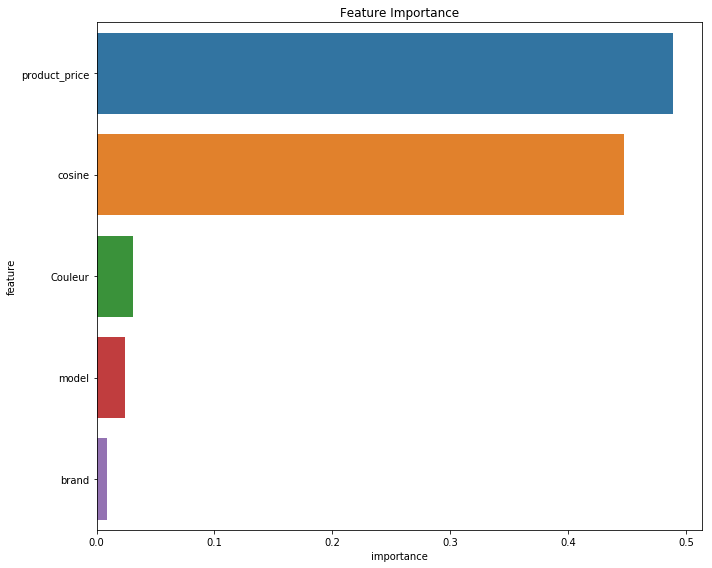

In [105]:
# Calcul des Features Importances
dict_feature_importance = {'feature': list_features+["cosine"], 'importance': clf.feature_importances_}
feature_importances = pd.DataFrame(data=dict_feature_importance).sort_values('importance', ascending=False)


plt.figure(figsize=(10,8))
sns.barplot(x="importance",
            y="feature",
            orient='h',
            data=feature_importances.sort_values(by="importance",
                                                 ascending=False))
plt.title('Feature Importance')
plt.tight_layout()

### Final Model

In [106]:
# Keep only categories with more than 20 products
labels_to_keep = df.label.value_counts()[df.label.value_counts()>19].index
df_reduced = df[df.label.isin(labels_to_keep)]

# # Keep only product identifiers that is represented by at leats 2 products
list_products_to_keep = df_reduced.id_page.value_counts().index.values[df_reduced.id_page.value_counts()>1]
df_reduced = df_reduced[df_reduced.id_page.isin(list_products_to_keep)]

df_reduced.reset_index(drop=True, inplace=True)

In [107]:
df_reduced.head(2)

id_page  index_data  label  \
0  /type/7612895071961.html           0     27   
1  /type/7612895071961.html           0     27   

                                                                                    productseller_name  \
0  sikaceram xtra, colle à carrelage intérieur et extérieur pour carreaux 60x60 max (c2-et), 25kg, ...   
1  sikaceram xtra, colle à carrelage intérieur et extérieur pour carreaux 60x60 max (c2-et), 25kg, ...   

  brand  \
0  sika   
1  sika   

                                                                     Description  \
0  ceram xtra colle à carrelage intérieur et extérieur pour carreaux max c2 et     
1  ceram xtra colle à carrelage intérieur et extérieur pour carreaux max c2 et     

   Volume_unit  Mesure_unit  Poids_unit  AmpereHeure  NewtonMetre  Watt  Volt  \
0          NaN          NaN     25000.0          NaN          NaN   NaN   NaN   
1          NaN          NaN     25000.0          NaN          NaN   NaN   NaN   

   Rpm  Joules  Metre2 Batterie Couleur  product_price  model  \
0  NaN     NaN     NaN            blanc          31.40  60x60   
1  NaN     NaN     NaN            blanc          36.77  60x60   

                                             Description_clean  topic_0  \
0  interieur coller max ceram carreau exterieur xtra carrelage      0.0   
1  interieur coller max ceram carreau exterieur xtra carrelage      0.0   

   topic_1  topic_2  topic_3  topic_4  topic_5  topic_6  topic_7  topic_8  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   topic_9  topic_10  topic_11  topic_12  topic_13  topic_14  topic_15  \
0      0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1      0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   topic_16  topic_17  topic_18  topic_19  topic_20  topic_21  topic_22  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   topic_23  topic_24  topic_25  topic_26  topic_27  topic_28  topic_29  \
0       0.0       0.0       0.0       0.0   0.06483       0.0       0.0   
1       0.0       0.0       0.0       0.0   0.06483       0.0       0.0   

   topic_30  topic_31  topic_32  topic_33  topic_34  topic_35  topic_36  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   topic_37  topic_38  topic_39  topic_40  topic_41  topic_42  topic_43  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   topic_44  topic_45  topic_46  topic_47  topic_48  topic_49  topic_50  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   topic_51  topic_52  topic_53    ...      topic_175  topic_176  topic_177  \
0       0.0       0.0       0.0    ...            0.0        0.0        0.0   
1       0.0       0.0       0.0    ...            0.0        0.0        0.0   

   topic_178  topic_179  topic_180  topic_181  topic_182  topic_183  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   

   topic_184  topic_185  topic_186  topic_187  topic_188  topic_189  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   

   topic_190  topic_191  topic_192  topic_193  topic_194  topic_195  \
0        0.0   0.017604        0.0        0.0        0.0        0.0   
1        0.0   0.017604        0.0        0.0        0.0        0.0   

   topic_196  topic_197  topic_198  topic_199  topic_200  topic_201  \
0        0.0        0.0        0.0        0.0        0.0     

In [108]:
# Create models for every classifier and evaluate
list_accuracy = []
list_recall = []
list_precision = []
list_f1score = []
categories = df_reduced.label.unique()
for category in categories:
    # Select Category
    df_category = df_reduced[df_reduced.label == category]
    # Select attributes and fill
    df_category = select_fill_attributes(df_category, list_units, 0.5)
    list_units_to_keep = df_category.columns[df_category.columns.isin(list_units)].values.tolist()
    list_features =  list_attributes_standard + list_units_to_keep
    # Compute distances
    distances = distance_pairwise(df_category[list_features])
    cosine_distances = np.array(cosine_pairwise(df_category[topics])).reshape(-1, 1)
    # Create variables
    X = np.concatenate((distances, cosine_distances), axis=1)
    y = np.array(create_labels(df_category.id_page.values))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)
    # Classifier
    clf = ExtraTreesClassifier(n_estimators=100, random_state=2, n_jobs=-1)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    # Scores
    list_accuracy.append(accuracy_score(prediction, y_test))
    list_recall.append(recall_score(prediction, y_test))
    list_precision.append(precision_score(prediction, y_test))
    list_f1score.append(f1_score(prediction, y_test))

In [109]:
# Evaluation
print("accuracy : ", np.mean(list_accuracy), "\n")
print("recall : ", np.mean(list_recall))
print("precision : ", np.mean(list_precision))
print("f1_score : ", np.mean(list_f1score))

accuracy :  0.9470457001595556 

recall :  0.8762204597228831
precision :  0.8452209839306165
f1_score :  0.8564548224905605


========================================================         
Evaluation TF-IDF(max_f=max_vocab) / NMF(250 topics) 

accuracy :  0.9524535261649251 

recall :  0.8843964840365431        
precision :  0.8413797735135053         
f1_score :  0.8582750788116252          

========================================================         
Evaluation TF-IDF(max_f=500) / NMF(250 topics)

accuracy :  0.9422341118650616 

recall :  0.8626140257758956            
precision :  0.8387882269396022          
f1_score :  0.8478399148406777        

========================================================         
Evaluation TF-IDF(max_f=500) / NMF(100 topics)

accuracy :  0.9347147147087409 

recall :  0.8444163586831299         
precision :  0.8245403432891271         
f1_score :  0.832141045037699            

========================================================         
Evaluation TF-IDF(max_f=250)

accuracy :  0.933205714134982 

recall :  0.84008775015275       
precision :  0.8219992193446757          
f1_score :  0.8274013271358288            